# NLP Super Stars --  A Natural Language Processing Project
Jared Vahle, Joshua Bryant, Hector Rodriguez, Sarah Lawson Woods - November 2021

In [1]:
import requests
from bs4 import BeautifulSoup 

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import re
from pprint import pprint

from wordcloud import WordCloud
from modeling import *

import os
import json

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

from prepare import *

import nltk
import nltk.sentiment

import warnings


In [2]:
warnings.filterwarnings('ignore')
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-darkgrid')
sia = nltk.sentiment.SentimentIntensityAnalyzer()

# Acquire

In [3]:
# pulling in the data from a json that included all the readme's in the repo list
data = pd.read_json('data.json')

In [4]:
# taking a look at the contents
data.head()

,repo,language,readme_contents
0,thedaviddias/Front-End-Checklist,None,"<h1 align=""center"">\n<br>\n <img src=""https:/..."
1,onevcat/Kingfisher,Swift,"<p align=""center"">\n<img src=""https://raw.gith..."
2,FallibleInc/security-guide-for-developers,None,# 实用性 WEB 开发人员安全须知 \n\n### 目标读者 \n\n安全问题主要由以...
3,tailwindlabs/tailwindcss,JavaScript,"<p>\n <a href=""https://tailwindcss.com/"" ta..."
4,codepath/android_guides,None,# CodePath Android Cliffnotes\n\nWelcome to th...


### Acquire Takeaway
- The data was acquired by scaping the starred repos on GitHub number 1001-1009 and then 10010-10060; we chose these specific repos in order to avoid the first ones that mostly included guides and some unfinished products, we also wanted to make sure we had some variety so we pulled some that were further down the list.
- We brought in 506 rows initially 

# Prepare

In [5]:
# Let's check for missing values in the language column
data.isna().sum()

repo                0
language           54
readme_contents     0
dtype: int64

In [6]:
# removed languages that were 'none'
data = data.dropna()

In [7]:
len(data)

506

In [8]:
# Let's see what values we have for each type of language
data.language.value_counts()

JavaScript          141
Python               59
Java                 46
TypeScript           45
Go                   36
C++                  30
C                    20
Swift                13
Shell                13
HTML                 12
Rust                 11
C#                    9
Ruby                  9
Kotlin                9
Vim script            6
Vue                   6
Jupyter Notebook      6
PHP                   6
CSS                   5
Objective-C           3
Elixir                2
Lua                   2
Haskell               2
CoffeeScript          2
TeX                   2
Batchfile             1
Emacs Lisp            1
Rascal                1
Clojure               1
AsciiDoc              1
Crystal               1
Dart                  1
Makefile              1
Dockerfile            1
Standard ML           1
OCaml                 1
Name: language, dtype: int64

In [9]:
# brought the dataset down to those languages that were more than or equal to 30
data = data[data['language'].map(data['language'].value_counts()) >= 30]

In [10]:
# Check out the number of repos we will be examining
len(data)

357

### Language Counts

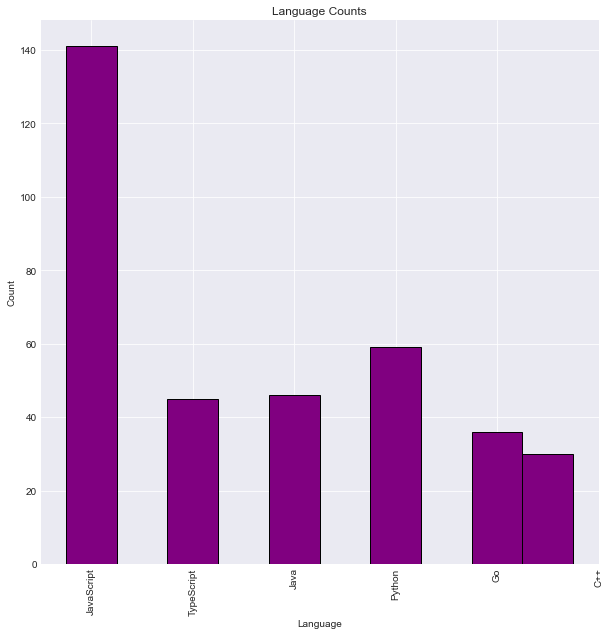

In [11]:
plt.figure(figsize=(10, 10))
data.language.hist(align = 'left', color = 'purple', ec = 'k')
plt.title('Language Counts')
plt.xlabel('Language')
plt.ylabel('Count')
plt.xticks(rotation = 90)
plt.show()

In [12]:
# Here we checked to make sure all of the null values were removed above by our drop 
data.isna().sum()

repo               0
language           0
readme_contents    0
dtype: int64

In [13]:
# Next we use our prep function that takes in a df and the string name for a text column with the option to 
# pass lists for extra_words and exclude_words and returns a df with the readme text, original text and stemmed 
# text, lemmatized text, cleaned, tokenized, & lemmatized text with stopwords removed.
data = prep_readme_data(df= data, column = 'readme_contents', extra_words=['https','p','com','http','href'], exclude_words=[])

In [14]:
# At this point we dropped the original contents since we had it in all the forms we need for exploration and 
# modeling
data = data.drop(columns = ['readme_contents'])

In [15]:
# This function gives us message length, word count and average word length added as columns to the df
data = get_columns(data)

In [16]:
# Here we made a column named is_javascript to hold all rows that the language column indicated were javascript
data['is_javascript'] = data.apply(lambda row: is_javascript(row), axis=1)

In [17]:
# And here we made a column named sentiment to tell us the aggregate sentiment of the 
# text of each readme
data['sentiment'] = data.clean.apply(lambda doc: sia.polarity_scores(doc)['compound'])

In [18]:
# Taking a look at the modified data
data

,repo,language,clean,stemmed,lemmatized,message_length,word_count,avg_word_length,is_javascript,sentiment
3,tailwindlabs/tailwindcss,JavaScript,utilityfirst cs framework rapidly building cus...,utilityfirst cs framework rapidli build custom...,utilityfirst c framework rapidly building cust...,549,48,11.437500,True,0.9349
5,github/fetch,JavaScript,windowfetch polyfill fetch function promisebas...,windowfetch polyfil fetch function promisebas ...,windowfetch polyfill fetch function promisebas...,1882,209,9.004785,True,0.8481
7,ianstormtaylor/slate,TypeScript,completely customizable framework building ric...,complet customiz framework build rich text edi...,completely customizable framework building ric...,7461,718,10.391365,False,0.9986
8,Kong/insomnia,JavaScript,insomnia rest client slack channelhttpschatins...,insomnia rest client slack channelhttpschatins...,insomnia rest client slack channelhttpschatins...,3120,311,10.032154,True,0.8720
9,CymChad/BaseRecyclerViewAdapterHelper,Java,httpsuserimagesgithubusercontentcom76982093319...,httpsuserimagesgithubusercontentcom76982093319...,httpsuserimagesgithubusercontentcom76982093319...,2027,74,27.391892,False,0.9729
...,...,...,...,...,...,...,...,...,...,...
551,TheAlgorithms/Java,Java,httpsgithubcomthealgorithmsjavatreedevelopment...,httpsgithubcomthealgorithmsjavatreedevelop jav...,httpsgithubcomthealgorithmsjavatreedevelopment...,4485,243,18.456790,False,0.0000
555,tornadoweb/tornado,Python,tornado web server image httpsbadgesgitterimjo...,tornado web server imag httpsbadgesgitterimjoi...,tornado web server image httpsbadgesgitterimjo...,911,92,9.902174,False,0.6808
557,gulpjs/gulp,JavaScript,streaming build system npm versionnpmimagenpmu...,stream build system npm versionnpmimagenpmurl ...,streaming build system npm versionnpmimagenpmu...,6677,734,9.096730,True,0.9963
558,alibaba/weex,C++,weex framework building mobile crossplatform u...,weex framework build mobil crossplatform ui bu...,weex framework building mobile crossplatform u...,807,43,18.767442,False,0.6124


In [19]:
# Splitting our data for exploration
train, test = train_test_split(data, train_size = 0.8, random_state = 123, stratify=data.is_javascript)

### Takeaways
- In the stage of the pipeline we checked for null values and dropped all rows missing a value in the language column since we had more than enough rows without the 54 that we ended up dropping here
- We then looked at the value counts for each language and decided to drop all the languages that contained less than 30 readme's because we didnt want there to be a problem stratifying the sparse languages in each section of the split dataset
- The next step was to use our prep function stored in the prepare file that takes in a df and the string name for a text column with the option to pass lists for extra_words and exclude_words and returns a df with the readme text, cleaned text, stemmed text, lemmatized text, with stopwords removed from all columns.
- Next we removed the readme_contents column since we had no more use for it in explore or modeling
- We then used the get_columns function to give us message length, word count and average word length added as columns to the df
- We also created two columns named is_javascript to hold all rows that the language column indicated were javascript and a sentiment column to tell us the aggregate sentiment of the text of each readme
- Split our data on train and test


# Explore 

- We know that JavaScript makes up near 40% of the readme with the other 60% being non JavaScript

In [20]:
# Let's look at the language of each readme by percentage
train.language.value_counts(normalize = True)

JavaScript    0.396491
Python        0.164912
Java          0.129825
TypeScript    0.119298
Go            0.108772
C++           0.080702
Name: language, dtype: float64

In [21]:
# Taking a lookt at the number of readme's by language after the modifications in prepare
train.language.value_counts()

JavaScript    113
Python         47
Java           37
TypeScript     34
Go             31
C++            23
Name: language, dtype: int64

In [22]:
# Displaying the index dtype and columns, non-null values and memory usage
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285 entries, 408 to 220
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   repo             285 non-null    object 
 1   language         285 non-null    object 
 2   clean            285 non-null    object 
 3   stemmed          285 non-null    object 
 4   lemmatized       285 non-null    object 
 5   message_length   285 non-null    int64  
 6   word_count       285 non-null    int64  
 7   avg_word_length  284 non-null    float64
 8   is_javascript    285 non-null    bool   
 9   sentiment        285 non-null    float64
dtypes: bool(1), float64(2), int64(2), object(5)
memory usage: 22.5+ KB


In [23]:
# Generate descriptive statistics
train.describe()

,message_length,word_count,avg_word_length,sentiment
count,285.000000,285.000000,284.000000,285.000000
mean,8940.431579,821.459649,11.819445,0.816803
std,17972.987904,1558.423014,4.642698,0.419034
min,0.000000,0.000000,6.258373,-0.995700
25%,2338.000000,196.000000,9.058854,0.924600
50%,4063.000000,368.000000,10.373626,0.989400
75%,7361.000000,734.000000,13.102123,0.996600
max,141410.000000,11924.000000,41.034483,1.000000


In [24]:
# combine all messages in single string by label
JavaScript_words = clean(' '.join(train[train.language == 'JavaScript'].stemmed))
Python_words = clean(' '.join(train[train.language == 'Python'].stemmed))
TS_words = clean(' '.join(train[train.language == 'TypeScript'].stemmed))
Java_words = clean(' '.join(train[train.language == 'Java'].stemmed))
Go_words = clean(' '.join(train[train.language == 'Go'].stemmed))
C_words = clean(' '.join(train[train.language == 'C++'].stemmed))
Non_JavaScript = clean(' '.join(train[train.language != 'JavaScript'].stemmed))
all_words = clean(' '.join(train.stemmed))

# making a df for each language 
js_df = data[data.language == 'JavaScript']
python_df = data[data.language == 'Python']
java_df = data[data.language == 'Java']
ts_df = data[data.language == 'TypeScript']
go_df = data[data.language == 'Go']
c_df = data[data.language == 'C++']

In [25]:
# Looking at the frequency of word that appeared in the TypeScript readme
TS_freq = pd.Series(TS_words.split()).value_counts()
TS_freq

use         276
const       158
redux       125
selector    119
function    107
           ... 
lefthand      1
orchestr      1
dummi         1
defens        1
advertis      1
Length: 4262, dtype: int64

In [26]:
#Represent text as word frequencies
JavaScript_freq = pd.Series(JavaScript_words.split()).value_counts()
Python_freq = pd.Series(Python_words.split()).value_counts()
Java_freq = pd.Series(Java_words.split()).value_counts()
Go_freq = pd.Series(Go_words.split()).value_counts()
C_freq = pd.Series(C_words.split()).value_counts()
TS_freq = pd.Series(TS_words.split()).value_counts()
non_JavaScript_freq = pd.Series(Non_JavaScript.split()).value_counts()
all_words_freq = pd.Series(all_words.split()).value_counts()

In [27]:
# Created a dataframe of the word frequencies as they occurred above to include grand totals
word_counts = pd.concat([JavaScript_freq, Python_freq, Java_freq, Go_freq, C_freq, TS_freq,non_JavaScript_freq, all_words_freq], axis = 1).fillna(0).astype(int)
word_counts.columns = ['javascript','python','java','go','c','ts','NonJS','all']
word_counts.head()

,javascript,python,java,go,c,ts,NonJS,all
use,1083,698,160,234,229,276,1597,2680
javascript,770,41,3,1,2,50,97,867
j,690,5,2,7,43,89,146,836
function,639,142,16,32,65,107,362,1001
file,598,465,49,141,70,32,757,1355


In [28]:
# Here we put them in order from highest to lowest occurrences by total count in the all column
word_counts.sort_values('all', ascending = False).head(20)

,javascript,python,java,go,c,ts,NonJS,all
use,1083,698,160,234,229,276,1597,2680
file,598,465,49,141,70,32,757,1355
instal,377,442,37,107,89,85,760,1137
function,639,142,16,32,65,107,362,1001
support,353,270,112,91,105,69,647,1000
option,499,327,14,40,15,37,433,932
code,470,157,88,59,53,63,420,890
javascript,770,41,3,1,2,50,97,867
1,252,317,55,100,47,79,598,850
j,690,5,2,7,43,89,146,836


In [29]:
# Then we just sorted by NonJS and javascript columns only
word_counts.sort_values(['NonJS','javascript'],ascending = [True,False]).head(20)


,javascript,python,java,go,c,ts,NonJS,all
usa,177,0,0,0,0,0,0,177
nightmar,120,0,0,0,0,0,0,120
ccxt,119,0,0,0,0,0,0,119
est,99,0,0,0,0,0,0,99
nativo,83,0,0,0,0,0,0,83
worksheet,79,0,0,0,0,0,0,79
un,77,0,0,0,0,0,0,77
workbook,77,0,0,0,0,0,0,77
en,73,0,0,0,0,0,0,73
loadabl,63,0,0,0,0,0,0,63


In [30]:
# Here we sorted by javascript and then NonJS
word_counts.sort_values(['javascript','NonJS'],ascending = [True,False]).head(20)

,javascript,python,java,go,c,ts,NonJS,all
softwareoss,0,750,0,0,0,0,750,750
py,0,253,0,0,0,0,253,253
ycm,0,201,0,0,0,0,201,201
viper,0,0,0,81,0,0,81,81
viml,0,79,0,0,0,0,79,79
airflow,0,71,0,0,0,0,71,71
filetyp,0,70,0,0,0,0,70,70
fasthttp,0,0,0,70,0,0,70,70
boot,0,1,64,0,3,1,69,69
onnx,0,1,0,0,65,0,66,66


## Top 20

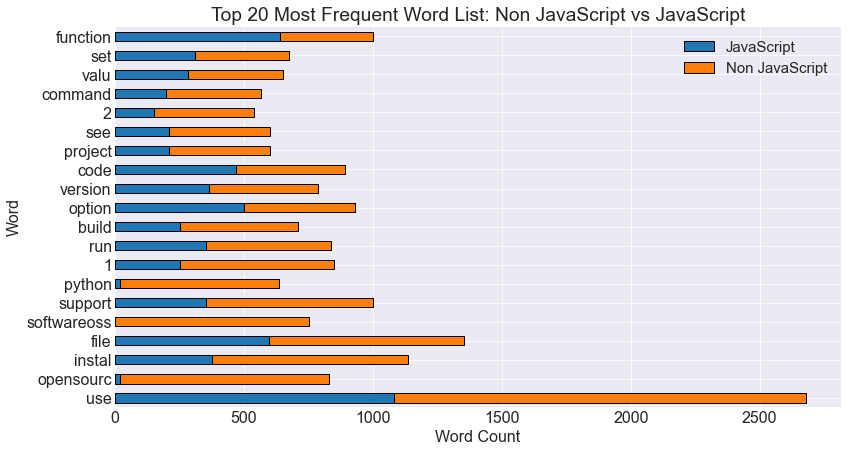

In [31]:
# Displayed the 20 most frequent word list by Non Javascript vs JavaScript
plt.rc('font', size=16)
word_counts.sort_values('NonJS', ascending=False).head(20)[['javascript','NonJS']].plot.barh(stacked = True, ec = 'k')#stacked and added bar border
plt.title('Top 20 Most Frequent Word List: Non JavaScript vs JavaScript')
plt.xlabel('Word Count')
plt.ylabel('Word')
plt.legend(['JavaScript', 'Non JavaScript'], fontsize = 15)
plt.show()

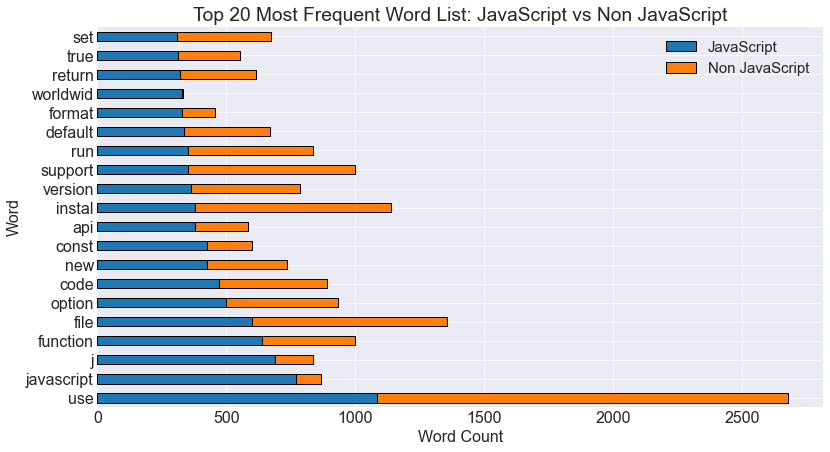

In [32]:
# Displayed the 20 most frequent word list by Javascript vs Non JavaScript
plt.rc('font', size=16)
word_counts.sort_values('javascript', ascending=False).head(20)[['javascript','NonJS']].plot.barh(stacked = True, ec = 'k')#stacked and added bar border
plt.title('Top 20 Most Frequent Word List: JavaScript vs Non JavaScript')
plt.xlabel('Word Count')
plt.ylabel('Word')
plt.legend(['JavaScript', 'Non JavaScript'], fontsize = 15)
plt.show()

## Top 20 Distribution

<Figure size 1152x648 with 0 Axes>

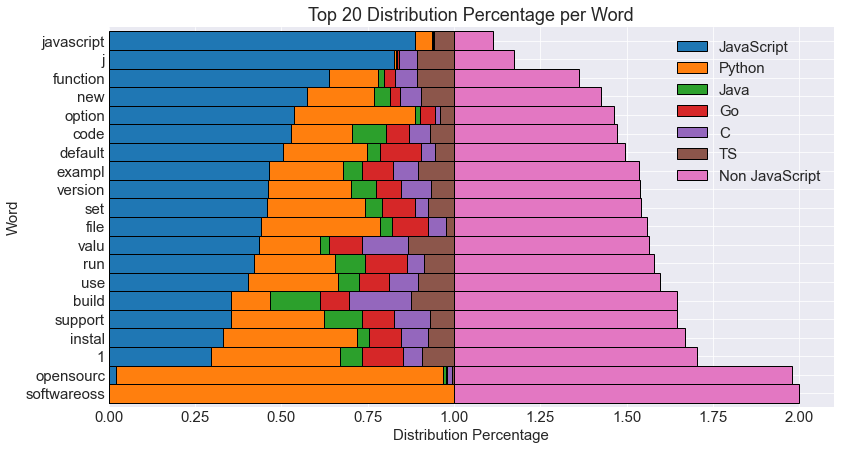

In [33]:
# Plotted the distribution percentages per word by language
plt.figure(figsize=(16, 9))
plt.rc('font', size=15)

(word_counts.sort_values('all', ascending=False)
 .head(20)
 .apply(lambda row: row/row['all'], axis = 1)
 .drop(columns = 'all')
 .sort_values(by = 'javascript')
 .plot.barh(stacked = True, width = 1, ec = 'k')
)
plt.title('Top 20 Distribution Percentage per Word')
plt.xlabel('Distribution Percentage')
plt.ylabel('Word')
plt.legend(['JavaScript', 'Python', 'Java', 'Go', 'C', 'TS', 'Non JavaScript'])
plt.show()

## Bigrams

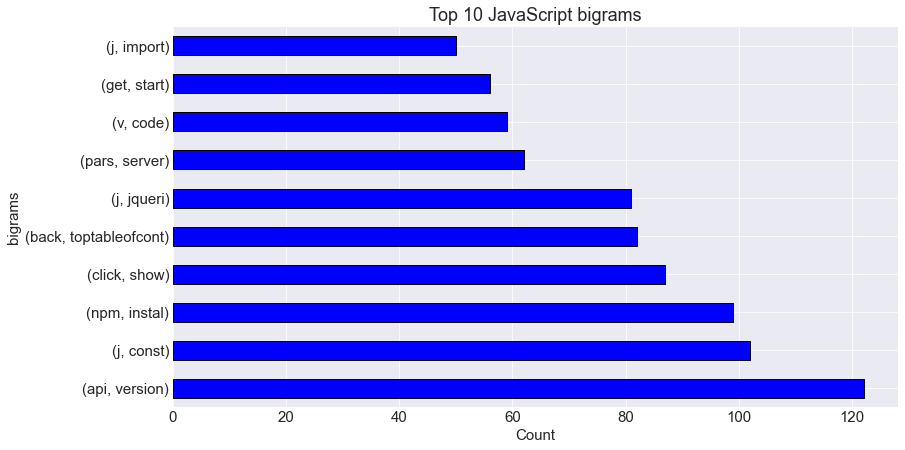

In [34]:
# Plotted the top 10 JavaScript bigrams
pd.Series(nltk.bigrams(JavaScript_words.split())).value_counts().head(10).plot.barh(color = 'blue',ec = 'k')
plt.title('Top 10 JavaScript bigrams')
plt.xlabel('Count')
plt.ylabel('bigrams')
plt.show()

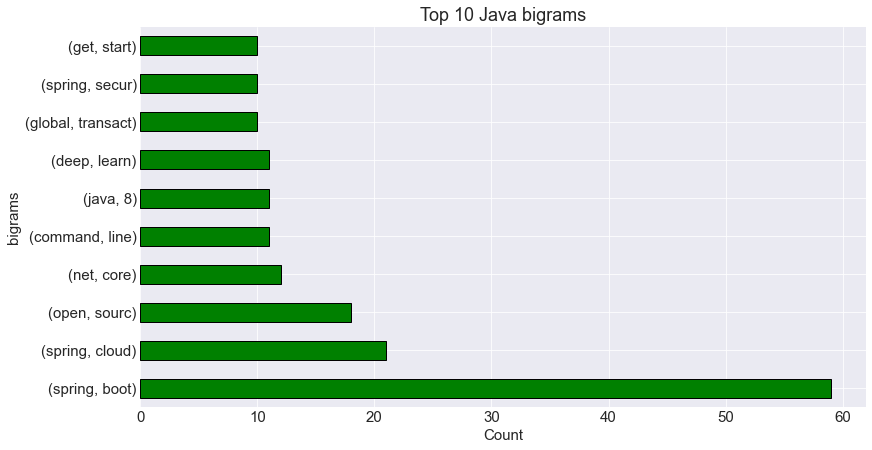

In [35]:
# Displaying the top Java bigrams
pd.Series(nltk.bigrams(Java_words.split())).value_counts().head(10).plot.barh(color = 'green',ec = 'k')#change bar color to reflect stacked chart above and outline
plt.title('Top 10 Java bigrams')
plt.xlabel('Count')
plt.ylabel('bigrams')
plt.show()

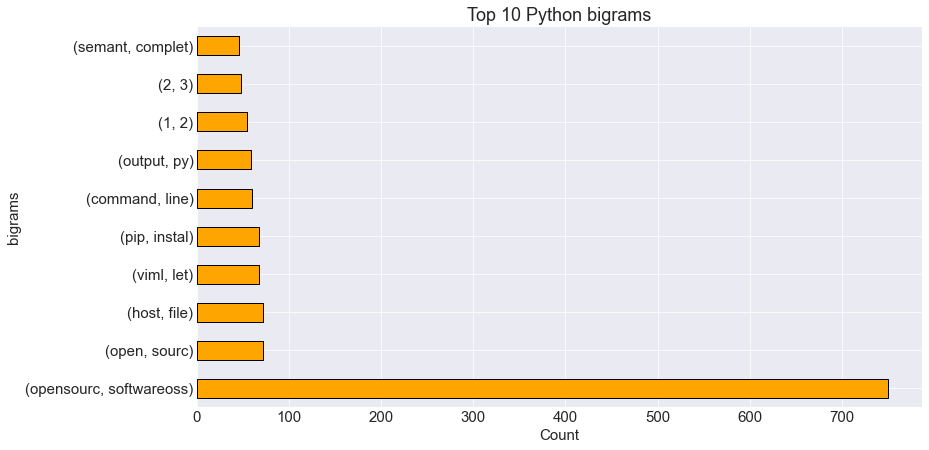

In [36]:
# Plotting the top 10 bigrams
pd.Series(nltk.bigrams(Python_words.split())).value_counts().head(10).plot.barh(color = 'orange',ec = 'k')#change bar color to reflect stacked chart above and outline
plt.title('Top 10 Python bigrams')
plt.xlabel('Count')
plt.ylabel('bigrams')
plt.show()

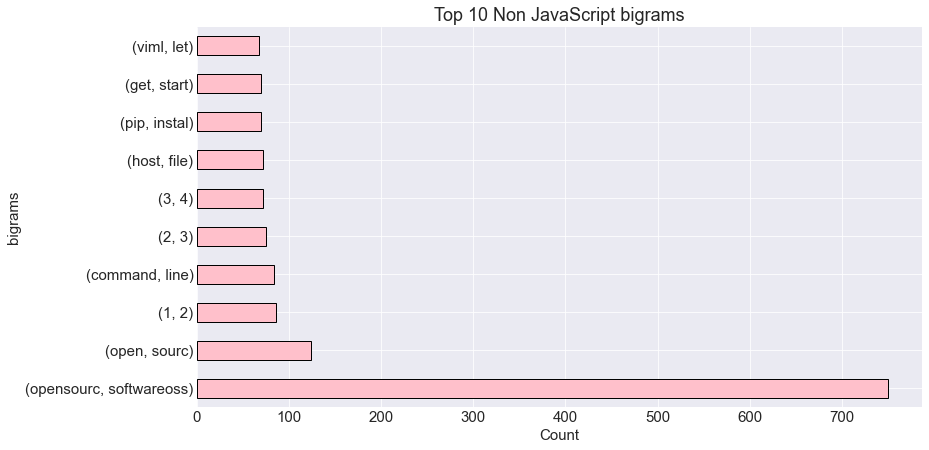

In [37]:
# Displaying the top 10 Non JavaScipt bigrams
pd.Series(nltk.bigrams(Non_JavaScript.split())).value_counts().head(10).plot.barh(color = 'pink',ec = 'k',)
plt.title('Top 10 Non JavaScript bigrams')
plt.xlabel('Count')
plt.ylabel('bigrams')
plt.show()

## Clouds

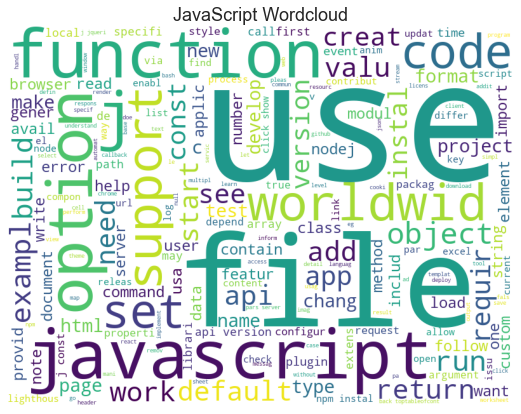

In [38]:
# Creating a wordcloud for JavaScript words
img = WordCloud(background_color='white', width=800, height=600).generate(JavaScript_words)
plt.title('JavaScript Wordcloud')
plt.imshow(img)
plt.axis('off')
plt.show()

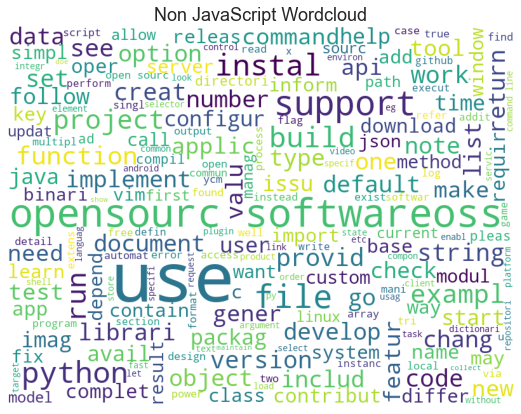

In [39]:
# Displaying a Non JavaScript wordcloud
img = WordCloud(background_color='white', width=800, height=600).generate(Non_JavaScript)
plt.title('Non JavaScript Wordcloud')
plt.imshow(img)
plt.axis('off')
plt.show()

## Relational Plots

### Language Relationships

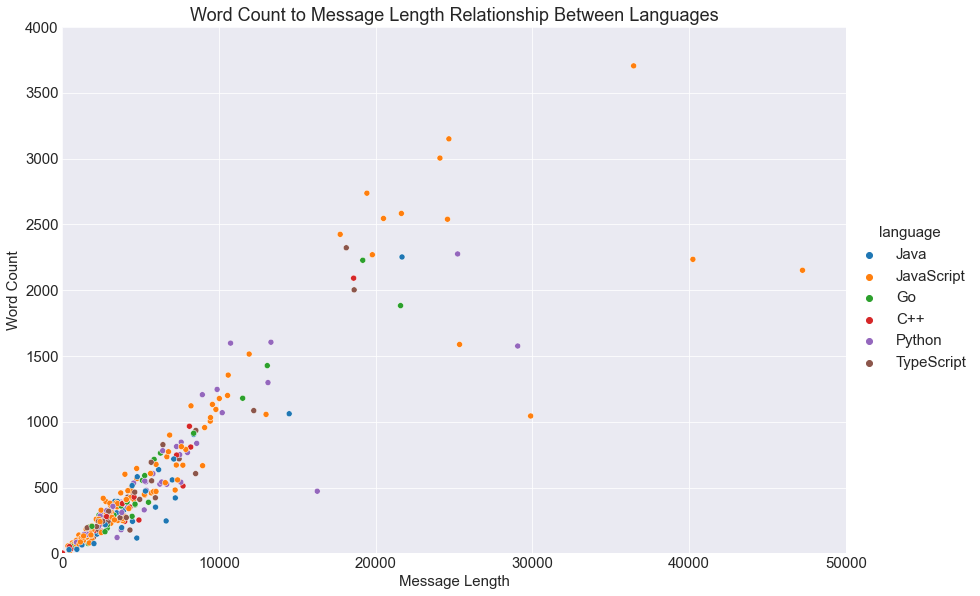

In [40]:
# Created a relpot to display word count to message length relationship between languages
plot = sns.relplot(data = train, x = 'message_length', y = 'word_count', hue = 'language', height = 8, aspect = 1.5)
plot.set(ylim=(0, 4000))
plot.set(xlim=(0,50000))
plt.title('Word Count to Message Length Relationship Between Languages')
plt.xlabel('Message Length')
plt.ylabel('Word Count')
plt.show()

#### Language Narrowed in Limits

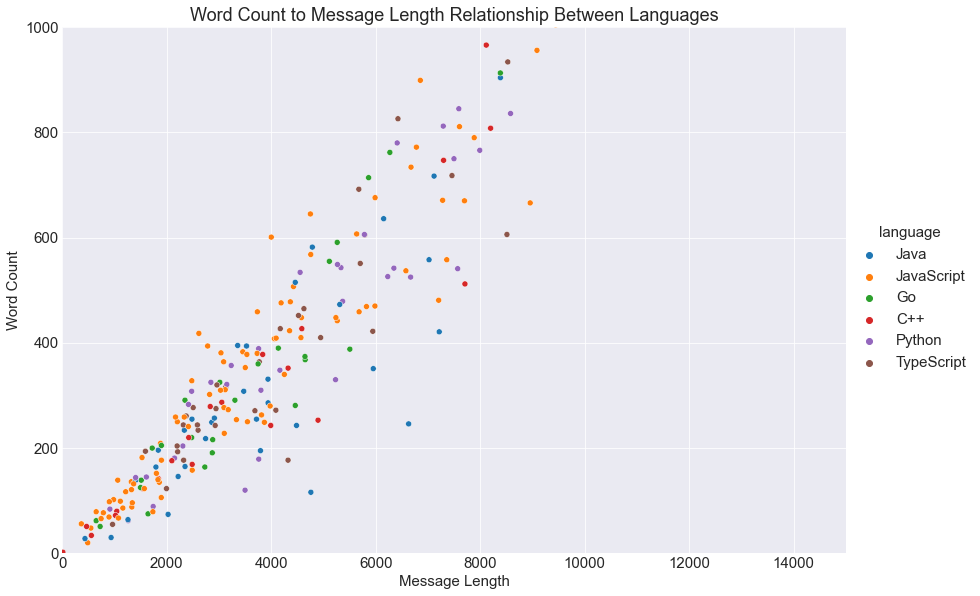

In [41]:
# A closer look at the above visualization
plot = sns.relplot(data = train, x = 'message_length', y = 'word_count', hue = 'language', height = 8, aspect = 1.5)
plot.set(ylim=(0, 1000))
plot.set(xlim=(0,15000))
plt.title('Word Count to Message Length Relationship Between Languages')
plt.xlabel('Message Length')
plt.ylabel('Word Count')
plt.show()

### JavaScript Relationships

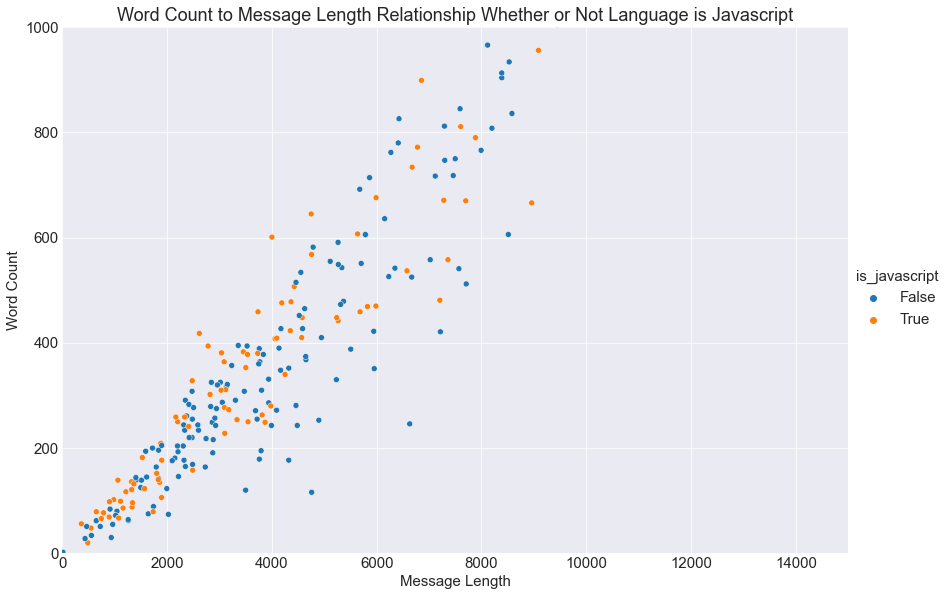

In [42]:
# Creating a relplot to display word count to message length relationship whether or not language is Javascript
plot = sns.relplot(data = train, x = 'message_length', y = 'word_count', hue = 'is_javascript', height = 8, aspect = 1.5)
plot.set(ylim=(0, 1000))
plot.set(xlim=(0,15000))
plt.title('Word Count to Message Length Relationship Whether or Not Language is Javascript')
plt.xlabel('Message Length')
plt.ylabel('Word Count')
plt.show()

#### Is_JavaScript Narrowed in limits

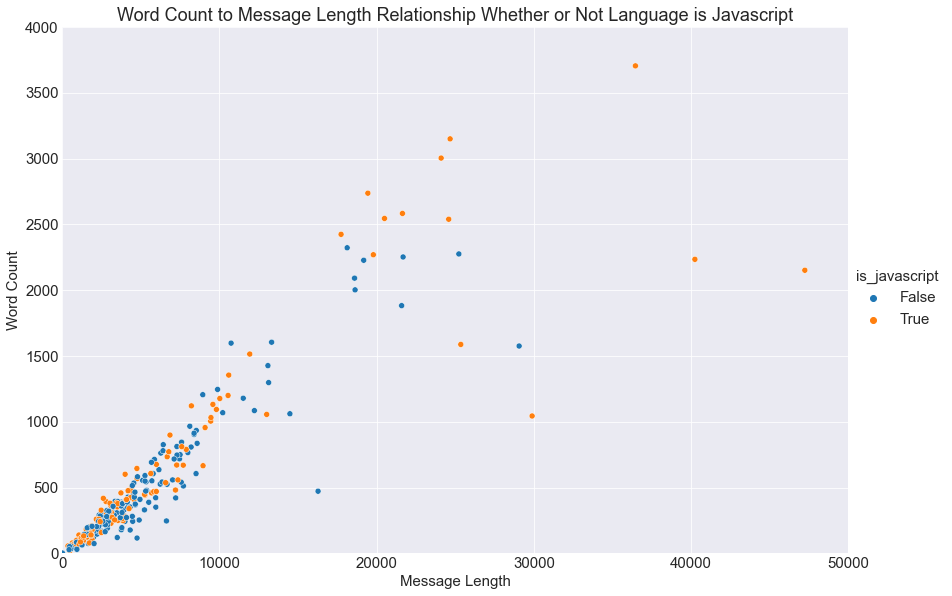

In [43]:
# A closer look at the above visualization
plot = sns.relplot(data = train, x = 'message_length', y = 'word_count', hue = 'is_javascript', height = 8, aspect = 1.5)
plot.set(ylim=(0, 4000))
plot.set(xlim=(0,50000))
plt.title('Word Count to Message Length Relationship Whether or Not Language is Javascript')
plt.xlabel('Message Length')
plt.ylabel('Word Count')
plt.show()

### Average Word Relationships

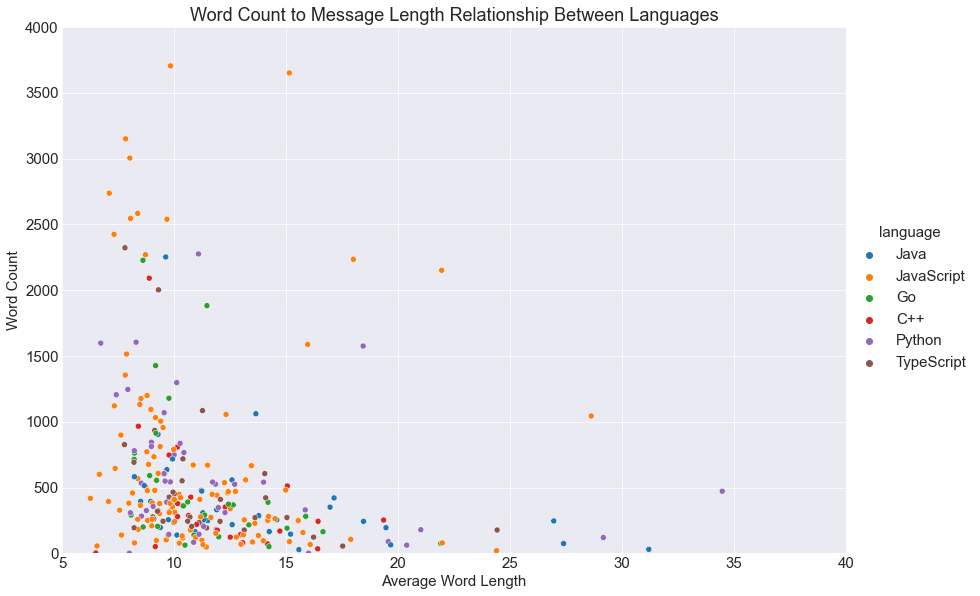

In [44]:
# Creating a replot of word count to message length with a hue of languages
plot = sns.relplot(data = train, x = 'avg_word_length', y = 'word_count', hue = 'language', height = 8, aspect = 1.5)
plot.set(ylim=(0, 4000))
plot.set(xlim=(5,40))
plt.title('Word Count to Message Length Relationship Between Languages')
plt.xlabel('Average Word Length')
plt.ylabel('Word Count')
plt.show()

#### Average Narrowed in Limits

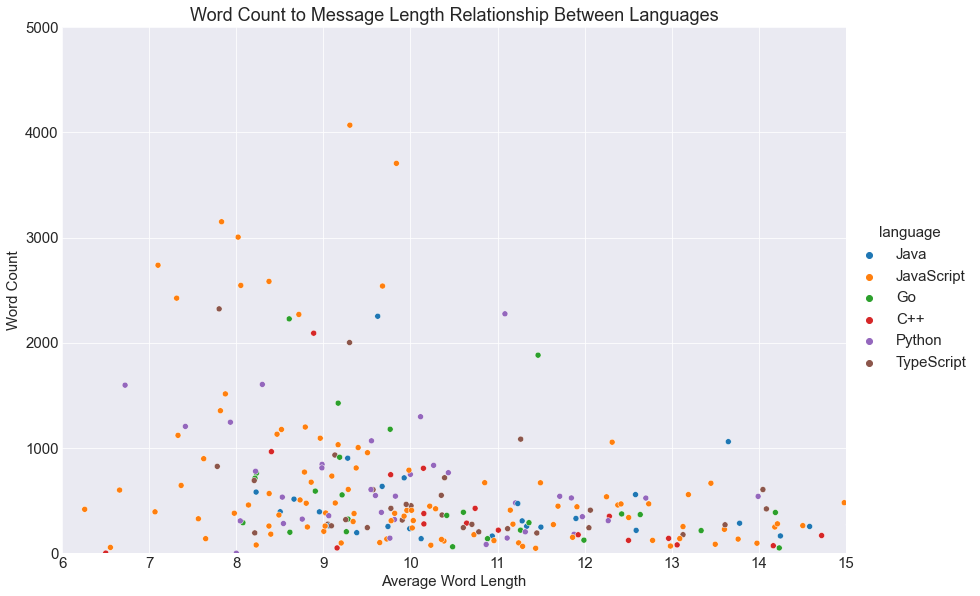

In [45]:
# Creating a relplot of word count to message length with a hue of languages
plot = sns.relplot(data = train, x = 'avg_word_length', y = 'word_count', hue = 'language', height = 8, aspect = 1.5)
plot.set(ylim=(0, 5000))
plot.set(xlim=(6,15))
plt.title('Word Count to Message Length Relationship Between Languages')
plt.xlabel('Average Word Length')
plt.ylabel('Word Count')
plt.show()

In [46]:
# Here we displayed the median and mean of message length, word count and sentiment in a df
train.groupby('language')['message_length','word_count','sentiment'].agg(['mean','median'])

message_length          word_count        sentiment        
                     mean median         mean median      mean  median
language                                                              
C++           6943.478261   3055   675.086957    253  0.833574  0.9833
Go            9474.645161   3750   762.612903    325  0.744468  0.9899
Java          8121.378378   3719   508.297297    257  0.664462  0.9681
JavaScript    9125.292035   4095   884.796460    418  0.864053  0.9918
Python       12556.425532   5368  1259.489362    526  0.780764  0.9880
TypeScript    5082.588235   3931   498.911765    318  0.929974  0.9917

In [47]:
# Next we grouped by whether or not they were Javascript or not
train.groupby('is_javascript').agg(['mean','median'])

message_length          word_count        avg_word_length  \
                        mean  median        mean median            mean   
is_javascript                                                             
False            8818.982558  3966.5  779.848837  327.5       12.364685   
True             9125.292035  4095.0  884.796460  418.0       10.994346   

                         sentiment          
                  median      mean  median  
is_javascript                               
False          10.784314  0.785760  0.9877  
True            9.926346  0.864053  0.9918

## Sentiment Values

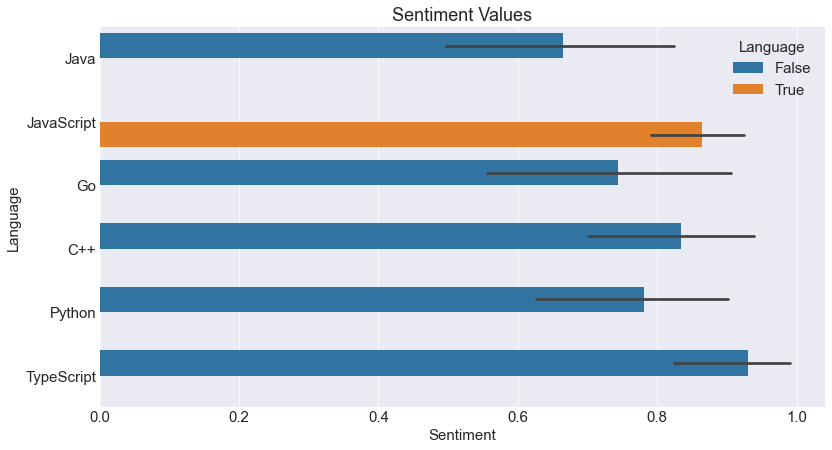

In [48]:
# This is plot of the compound aggregate sentiment by language
sns.barplot(data = train, x = 'sentiment', y = 'language', hue = 'is_javascript')
plt.title('Sentiment Values')
plt.xlabel('Sentiment')
plt.ylabel('Language')
plt.legend(loc = 'upper right', title = 'Language')
plt.show()

### Takeways
- We know that JavaScript makes up near 40% of the readme's with the other 60% being non JavaScript
- JS takes up 40%
- Top 5 JS - use, javascript, j, function, file
- Top 5 Non JS - use, opensourc, instal, file, softwareoss
- Top 3 JS bigrams are (api, version), (j, const), (nom, instal)
- Top 3 NJS bigrams are (opensourc, softwareoss), ( open, source), (1,2) 
- JS Wordclouds top 3 use, file, JavaScript 
- NJS wc t3 most common use, opensourc, softwareoss
- Average word length
- AVG JS is 885
- Avg NJS is 779
- AVG JS Sentiment 86%
- AVG NJS Sentiment 79%

# Modeling

In [49]:
# Bag of words
cv = CountVectorizer()
bag_of_words = cv.fit_transform(data.clean)

In [50]:
bag_of_words.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [51]:
pprint(data)

                                      repo    language  \
3                 tailwindlabs/tailwindcss  JavaScript   
5                             github/fetch  JavaScript   
7                     ianstormtaylor/slate  TypeScript   
8                            Kong/insomnia  JavaScript   
9    CymChad/BaseRecyclerViewAdapterHelper        Java   
..                                     ...         ...   
551                     TheAlgorithms/Java        Java   
555                     tornadoweb/tornado      Python   
557                            gulpjs/gulp  JavaScript   
558                           alibaba/weex         C++   
559                           dmlc/xgboost         C++   

                                                 clean  \
3    utilityfirst cs framework rapidly building cus...   
5    windowfetch polyfill fetch function promisebas...   
7    completely customizable framework building ric...   
8    insomnia rest client slack channelhttpschatins...   
9    httpsuse

In [52]:
# TFIDF 
tfidf = TfidfVectorizer()
bag_of_words = tfidf.fit_transform(data.clean)

pd.DataFrame(bag_of_words.todense(), columns=tfidf.get_feature_names()).sample(20)

,00,000,0000,00000,000000,00000001,0000001,00008384,0001,0001two,...,zxingcpprbhttpsgithubcomglassechidnazxingcpprb,zxingjslibraryhttpsgithubcomzxingjslibrary,zxingobjchttpsgithubcomthelevelupzxingobjc,zxingorg,zyclotropj,zyclotropjhttpsgithubcomzyclotropj,zyedidiamicro,zypehttpsboardsgreenhouseiozype,zypper,zyte
113,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
174,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
305,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
304,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
338,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
pd.Series(dict(zip(tfidf.get_feature_names(), tfidf.idf_))).sort_values()

use                   1.363080
using                 1.482370
support               1.509895
project               1.552657
code                  1.557523
                        ...   
fluxutils             6.187386
flvjs                 6.187386
flvminjs              6.187386
flutter929dart1031    6.187386
zyte                  6.187386
Length: 57624, dtype: float64

In [54]:
# Establishing our baseline on train
train.is_javascript.value_counts(normalize = True)

False    0.603509
True     0.396491
Name: is_javascript, dtype: float64

We chose to go with mode of our 'is_javascript' target variable to get our baseline

In [55]:
# Baseline: ~60.5

In [56]:
# Using Clean, Stemmed, lemmatized data on a MultinomialNB, and DecisionTreeClassifier.

In [57]:
# Getting the cleaned data
X = data
y = 'is_javascript'

X_train_clean, X_train_stemmed, X_train_lemmatized, y_train, X_test_clean, X_test_stemmed, X_test_lemmatized, y_test = data_split(X, y)

In [58]:
# Cleaned data with a MultinomialNB and a count vectorizer
cv = CountVectorizer()
X_bow = cv.fit_transform(X_train_clean)
clf = MultinomialNB(alpha=.01)
clf.fit(X_bow, y_train)

clf.score(X_bow, y_train)

1.0

In [59]:
# Cleaned data with a MultinomialNB and a TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X_train_clean)
clf = MultinomialNB(alpha=.01)
clf.fit(X_tfidf, y_train)

clf.score(X_tfidf, y_train)

1.0

In [60]:
# Cleaned data with a Decision Tree classifier and a count vectorizer
cv = CountVectorizer()
X_bow = cv.fit_transform(X_train_clean)
tree = DecisionTreeClassifier(max_depth=5)
tree.fit(X_bow, y_train)

tree.score(X_bow, y_train)

0.9298245614035088

In [61]:
# Cleaned data with a Decision Tree classifier and a TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X_train_clean)
tree.fit(X_tfidf,y_train)
tree.score(X_tfidf,y_train)

0.9543859649122807

In [62]:
# Stemmed data with a MultinomialNB and a count vectorizer
cv = CountVectorizer()
X_bow = cv.fit_transform(X_train_stemmed)
clf = MultinomialNB(alpha=.01)
clf.fit(X_bow, y_train)

clf.score(X_bow, y_train)

1.0

In [63]:
# Stemmed data with a MultinomialNB and a TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X_train_stemmed)
clf = MultinomialNB(alpha=.01)
clf.fit(X_tfidf, y_train)

clf.score(X_tfidf, y_train)

1.0

In [64]:
# Stemmed data with a Decision Tree classifier and a count vectorizer
cv = CountVectorizer()
X_bow = cv.fit_transform(X_train_stemmed)
tree = DecisionTreeClassifier(max_depth=5)
tree.fit(X_bow, y_train)

tree.score(X_bow, y_train)

0.9263157894736842

In [65]:
# Stemmed data with a Decision Tree classifier and a TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X_train_stemmed)
tree.fit(X_tfidf,y_train)
tree.score(X_tfidf,y_train)

0.9508771929824561

In [66]:
# Lemmatized data with a MultinomialNB and a count vectorizer
cv = CountVectorizer()
X_bow = cv.fit_transform(X_train_lemmatized)
clf = MultinomialNB(alpha=.01)
clf.fit(X_bow, y_train)

clf.score(X_bow, y_train)

1.0

In [67]:
# Lemmatized data with a MultinomialNB and a TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X_train_lemmatized)
clf = MultinomialNB(alpha=.01)
clf.fit(X_tfidf, y_train)

clf.score(X_tfidf, y_train)

1.0

In [68]:
# Lemmatized data with a Decision Tree classifier and a count vectorizer
cv = CountVectorizer()
X_bow = cv.fit_transform(X_train_lemmatized)
tree = DecisionTreeClassifier(max_depth=5)
tree.fit(X_bow, y_train)

tree.score(X_bow, y_train)

0.9368421052631579

In [69]:
# Lemmatized data with a Decision Tree classifier and a TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X_train_lemmatized)
tree.fit(X_tfidf,y_train)
tree.score(X_tfidf,y_train)

0.9508771929824561

In [70]:
tree.score(tfidf.transform(X_test_clean), y_test)

0.6805555555555556

In [71]:
predictions = make_predictions(clf,X_train_clean,X_test_clean,y_train)

In [72]:
# uses count vectorization on the cleaned data and makes a model report on the test predictions using a multinomialNB
model_report(y_test, predictions)


            *** Model  Report ***  
            ---------------------              
 _____________________________________________
|   Positive Case: is javascript = 'true'    |
|   Negative Case: is javascript = 'false'     |
|---------------------------------------------|
|                 Accuracy:   81.94%          |
|       True Positive Rate:   46.15%          |
|      False Positive Rate:   37.29%          |
|       True Negative Rate:   62.71%          |
|      False Negative Rate:   53.85%          |
|                Precision:   75.86%          |
|                   Recall:   78.57%          |
|                 F1-Score:   77.19%          |
|                                             |
|         Positive Support:       28          |
|         Negative Support:       44          |
|            Total Support:       72          |
|_____________________________________________|



### Takeaways
- Our best model was a Multinomial Naive Bayes model using count vectorization that performed with an accuracy of 81.94% on unseen data, beating our baseline by 21.44%

# Conclusion

Most of our conclusions were drawn in the exploration phase where we saw differences in distribution of words amongst the different programming languages. We also saw differences in the bigrams for different languages, but decided the most common words would be more useful during modeling.